#Beinjing Air Quality Forecast

In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#mount Google Drive, access API key & download datasets from competition
from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ALU/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c 'assignment-1-time-series-forecasting-may-2025'
!mkdir datasets
!unzip assignment-1-time-series-forecasting-may-2025.zip -d datasets

Mounted at /content/drive
  0% 0.00/839k [00:00<?, ?B/s]
100% 839k/839k [00:00<00:00, 1.40GB/s]
Archive:  assignment-1-time-series-forecasting-may-2025.zip
  inflating: datasets/test.csv       
  inflating: datasets/train.csv      


In [3]:
#Load datasets
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

#Explore the training data
In this sections explore your dataset with appropriate statistics and visualizations to understand your data better. Ensure that you explain the output of every code and what it entails.

In [4]:
# printing the first few rows
print("Training Data Overview:")
train.head(7)

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN
5,6,-1.442309,-1.840273,0.053790,-0.155751,-0.069353,-0.137667,2010-01-01 05:00:00,1.448138,-0.732019,-0.522096,NaN
6,7,-1.442309,-1.758296,0.053790,-0.093164,-0.069353,-0.137667,2010-01-01 06:00:00,1.448138,-0.732019,-0.522096,NaN


In [6]:
# Display basic information about the datasets
print(train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB
None


In [8]:
#description of data
print(train.describe())

                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      1.063811      1.006001    

In [9]:
#info about the testdatafram
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        13148 non-null  int64  
 1   DEWP      13148 non-null  float64
 2   TEMP      13148 non-null  float64
 3   PRES      13148 non-null  float64
 4   Iws       13148 non-null  float64
 5   Is        13148 non-null  float64
 6   Ir        13148 non-null  float64
 7   datetime  13148 non-null  object 
 8   cbwd_NW   13148 non-null  float64
 9   cbwd_SE   13148 non-null  float64
 10  cbwd_cv   13148 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.1+ MB
None


Let's try some plots

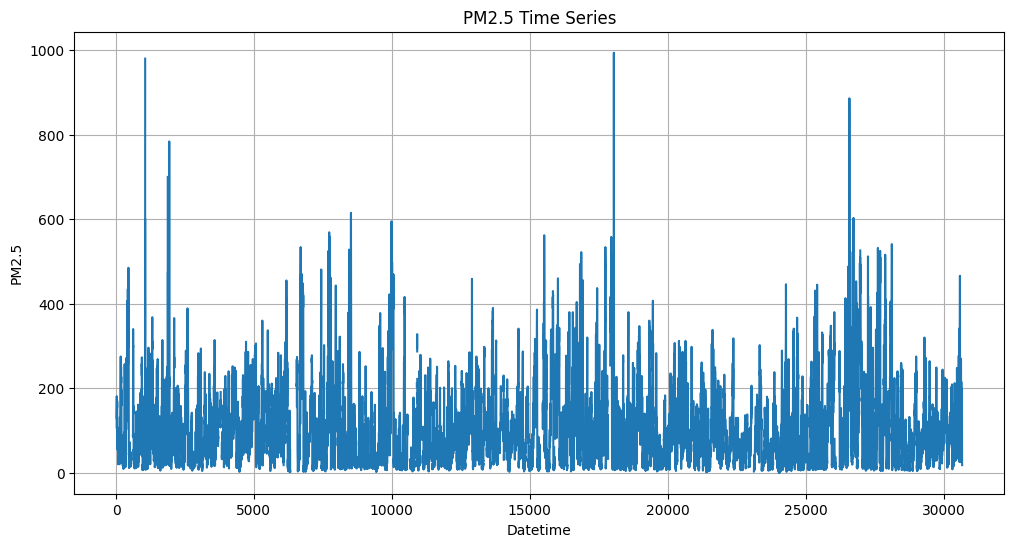

In [11]:
plt.style.use('default')
fig_size = (15, 8)

plt.figure(figsize=(12, 6))
plt.plot(train['pm2.5'])
plt.title('PM2.5 Time Series')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()

Let's try a bunch of plot to see what it tells us

In [12]:
for column in train:
  print(column)

No
DEWP
TEMP
PRES
Iws
Is
Ir
datetime
cbwd_NW
cbwd_SE
cbwd_cv
pm2.5


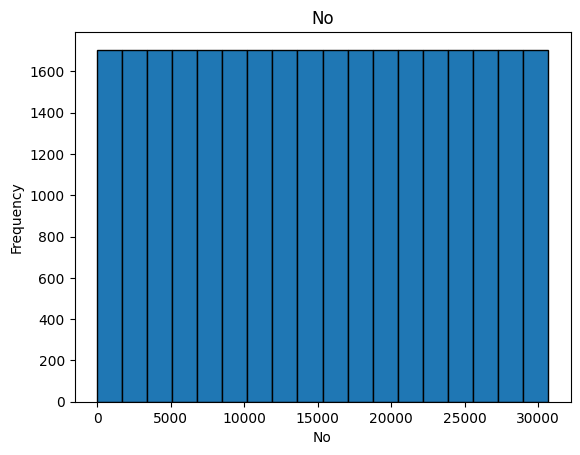

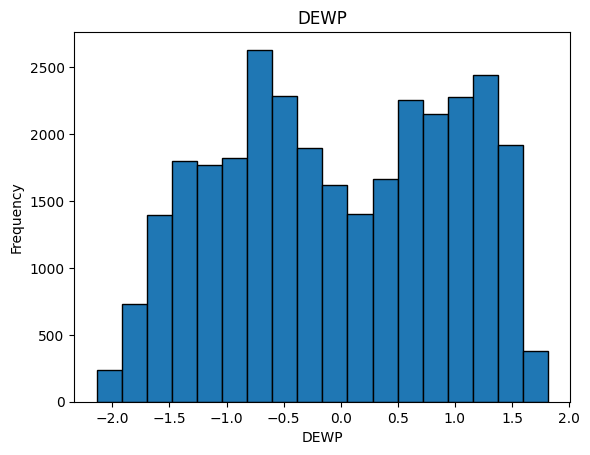

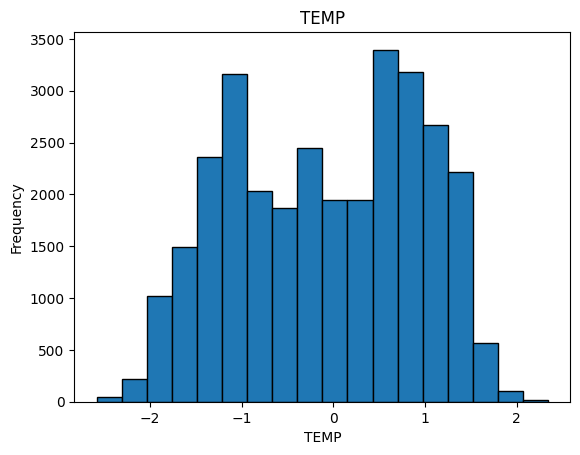

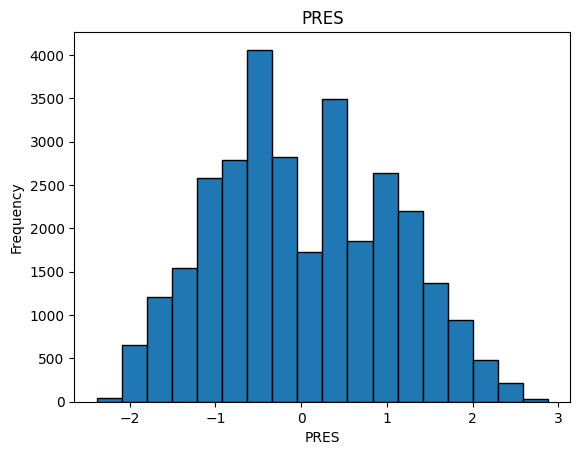

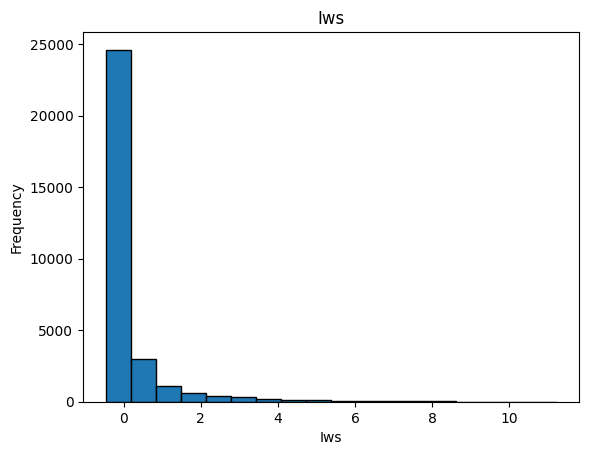

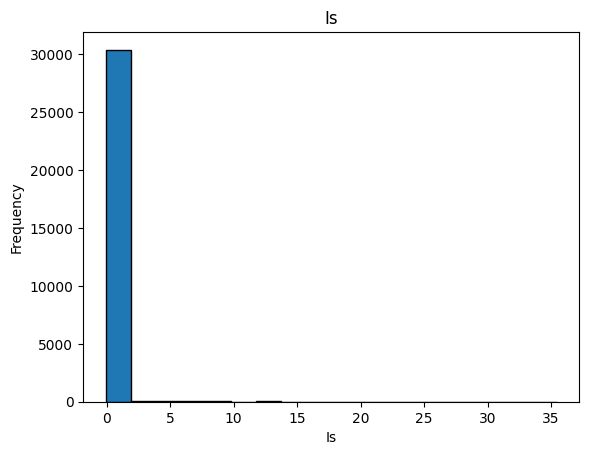

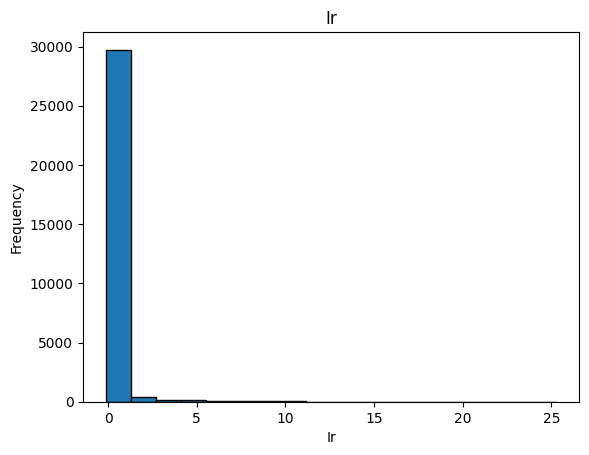

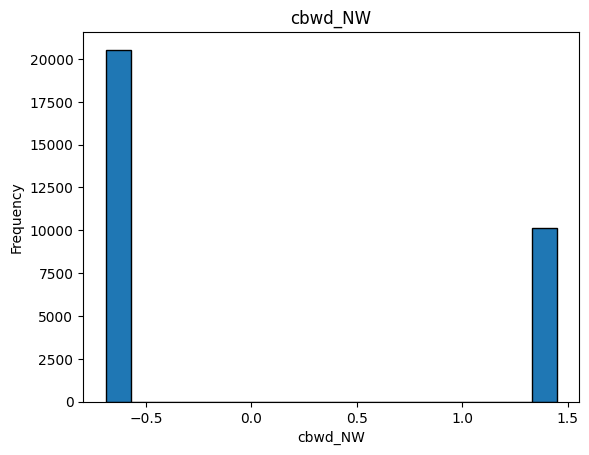

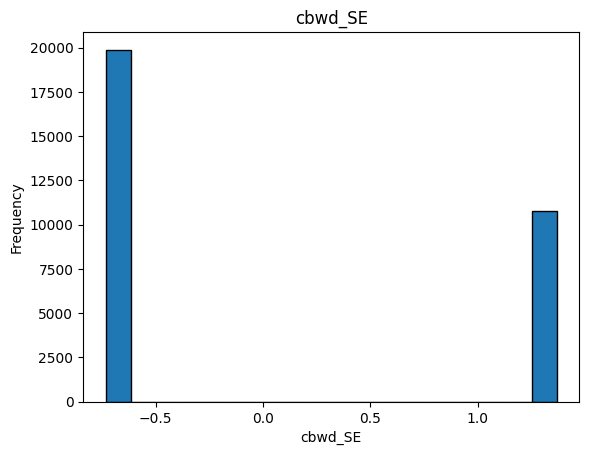

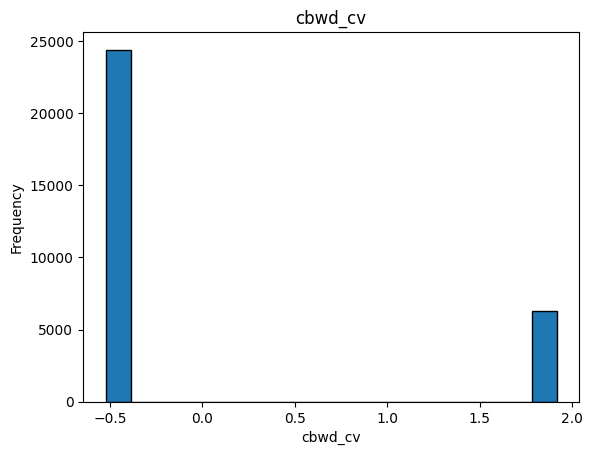

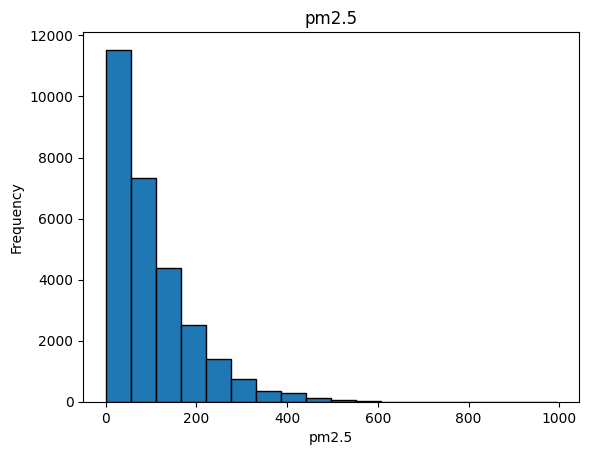

In [13]:
#plot histogram for every number columns
numerical = train.select_dtypes(include=np.number)
for column in numerical:
  numerical[column].plot(kind='hist',bins=18,edgecolor='black',title=column)
  plt.xlabel(column)
  plt.show()

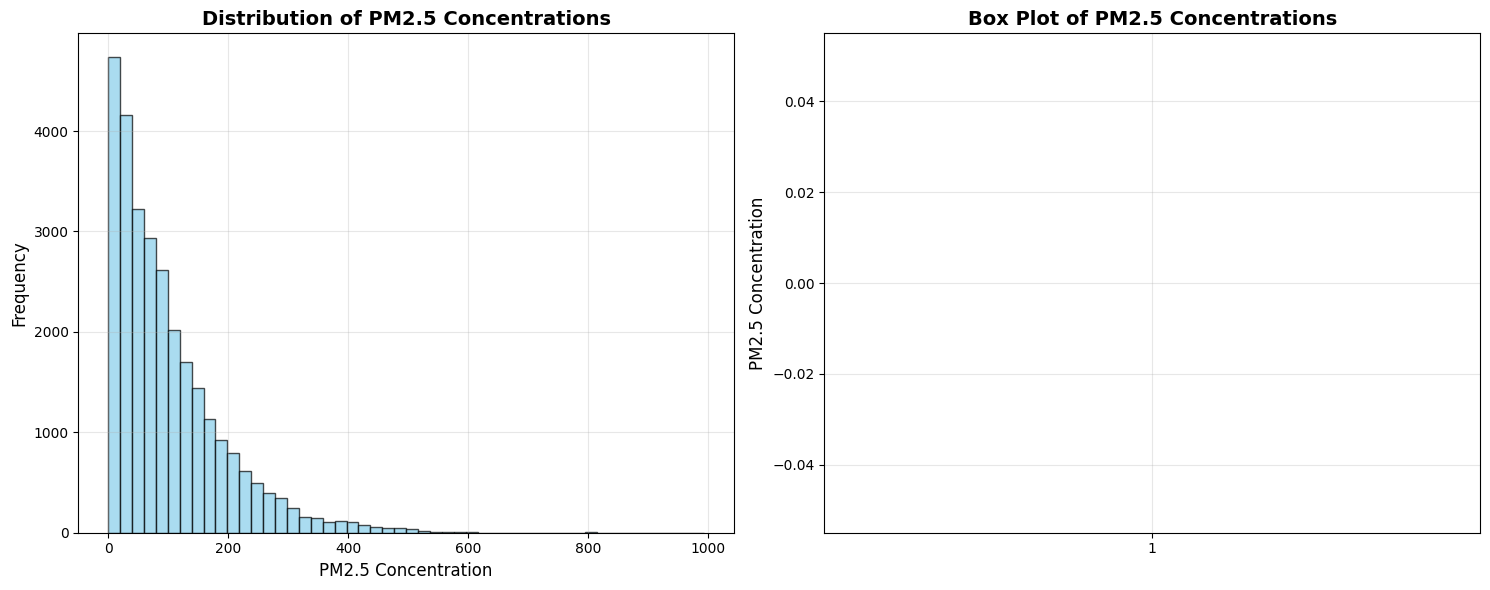

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(train['pm2.5'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of PM2.5 Concentrations', fontsize=14, fontweight='bold')
ax1.set_xlabel('PM2.5 Concentration', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, alpha=0.3)

ax2.boxplot(train['pm2.5'])
ax2.set_title('Box Plot of PM2.5 Concentrations', fontsize=14, fontweight='bold')
ax2.set_ylabel('PM2.5 Concentration', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

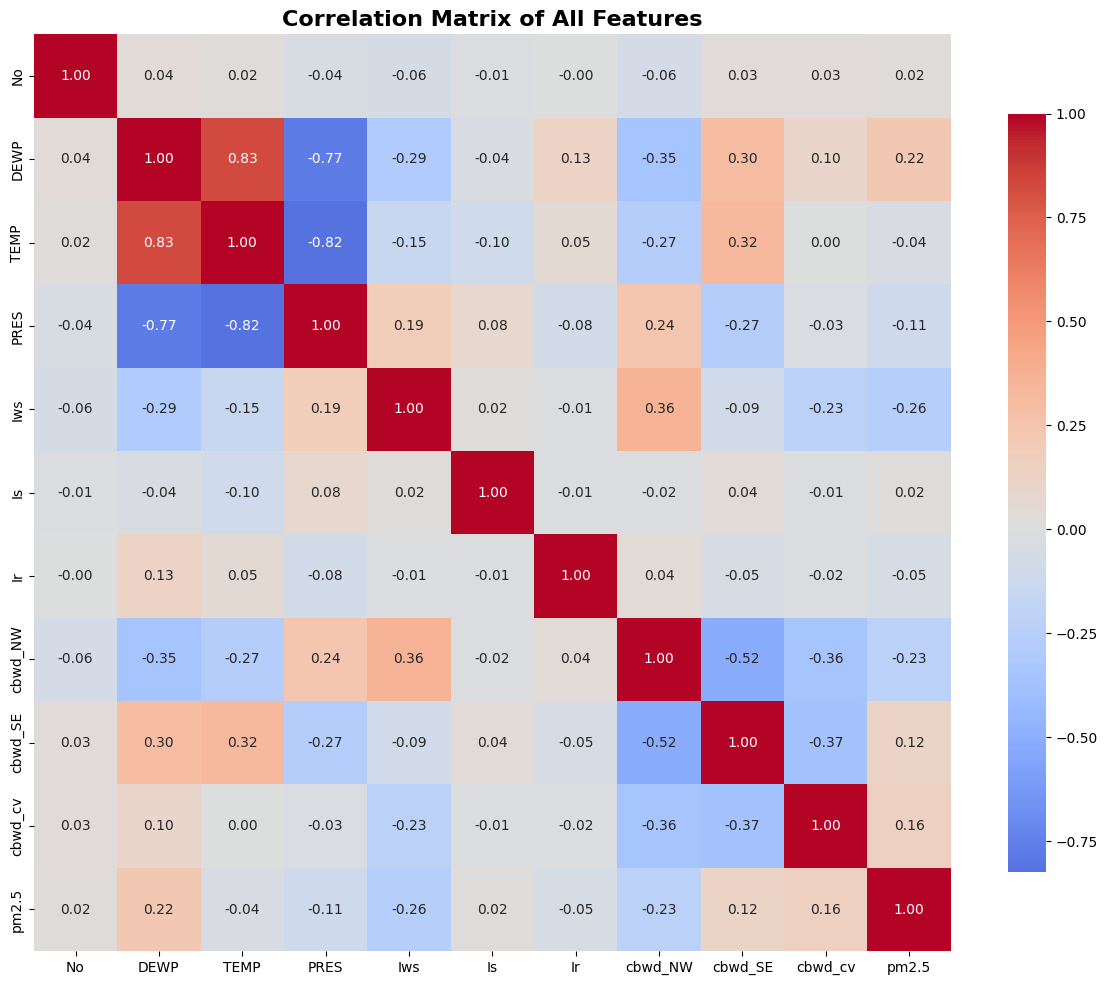

In [15]:
numeric_columns = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of All Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Let's try for more seasonal features

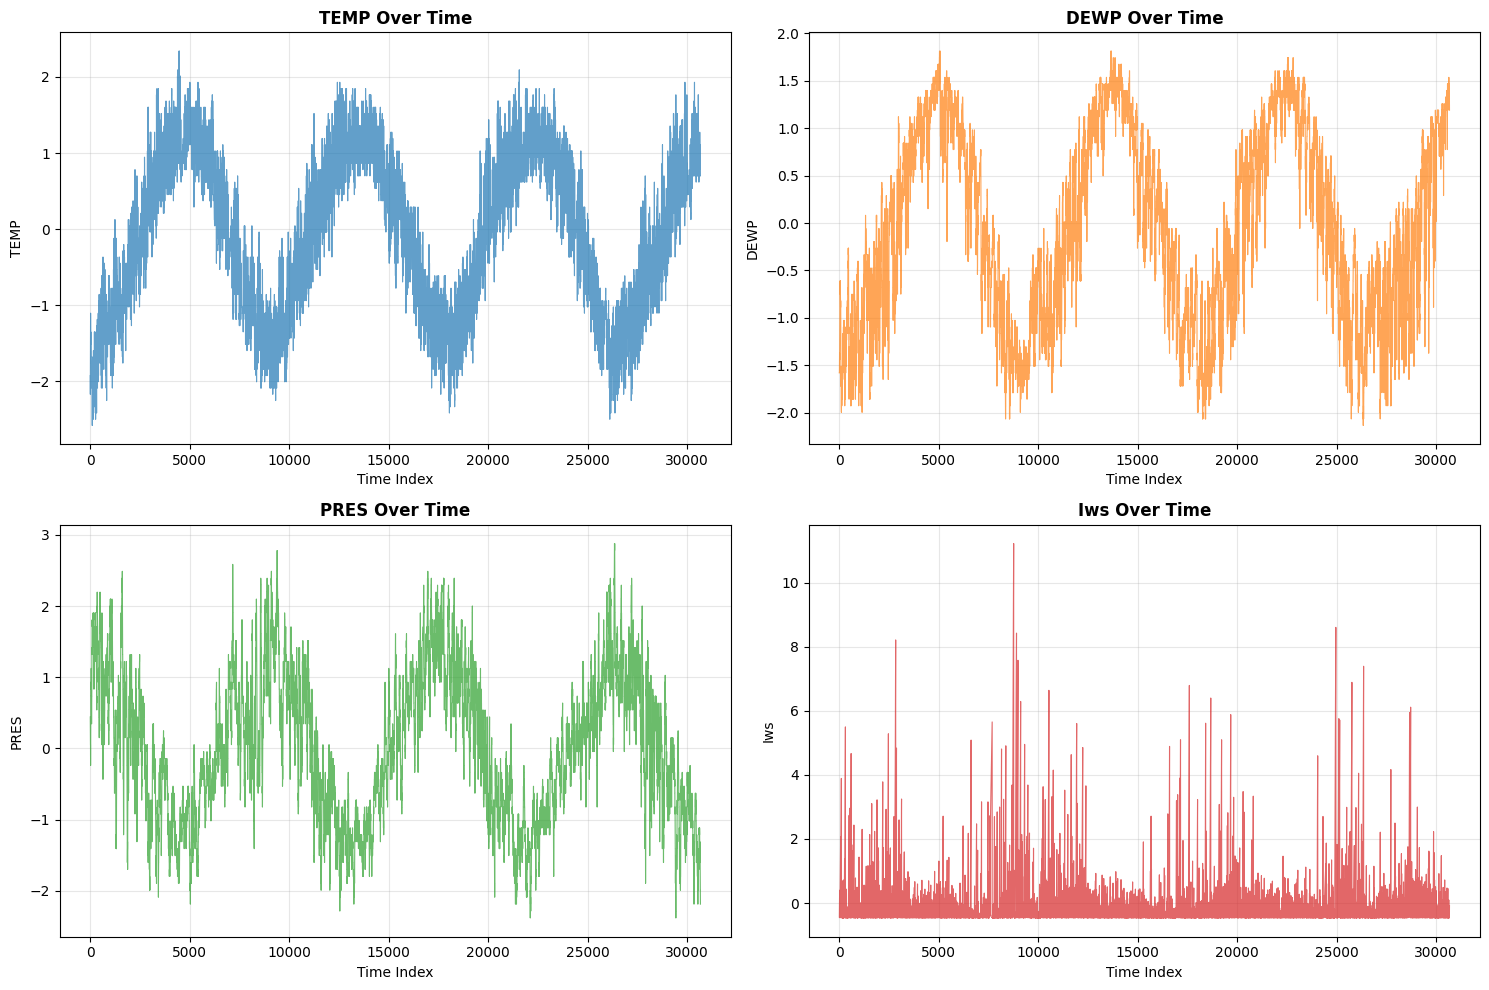

In [16]:
weather_features = ['TEMP', 'DEWP', 'PRES', 'Iws'] if all(col in train.columns for col in ['TEMP', 'DEWP', 'PRES', 'Iws']) else []

if weather_features:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(weather_features):
        axes[i].plot(train.index, train[feature], alpha=0.7, linewidth=0.8, color=f'C{i}')
        axes[i].set_title(f'{feature} Over Time', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Index', fontsize=10)
        axes[i].set_ylabel(feature, fontsize=10)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [18]:
# PM2.5 STATISTICAL SUMMARY
print(f"Mean: {train['pm2.5'].mean():.2f}")
print(f"Median: {train['pm2.5'].median():.2f}")
print(f"Standard Deviation: {train['pm2.5'].std():.2f}")
print(f"Minimum: {train['pm2.5'].min():.2f}")
print(f"Maximum: {train['pm2.5'].max():.2f}")
print(f"25th Percentile: {train['pm2.5'].quantile(0.25):.2f}")
print(f"75th Percentile: {train['pm2.5'].quantile(0.75):.2f}")

Mean: 100.79
Median: 75.00
Standard Deviation: 93.14
Minimum: 0.00
Maximum: 994.00
25th Percentile: 29.00
75th Percentile: 142.00


In [19]:
# Display basic descriptive statistics of the training data
print("\nTraining Data Descriptive Statistics:")
display(train.describe())


Training Data Descriptive Statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


 ## **DATA PREPROCESSING AND FEATURE ENGINEERING**


In [21]:
train_processed = train.copy()
test_processed = test.copy()

In [22]:
print(f"Missing values in training data before processing: {train_processed.isnull().sum().sum()}")
print(f"Missing values in test data before processing: {test_processed.isnull().sum().sum()}")

# Fill missing values with forward fill then backward fill
train_processed = train_processed.fillna(method='ffill').fillna(method='bfill')
test_processed = test_processed.fillna(method='ffill').fillna(method='bfill')

print(f"Missing values in training data after processing: {train_processed.isnull().sum().sum()}")
print(f"Missing values in test data after processing: {test_processed.isnull().sum().sum()}")


Missing values in training data before processing: 1921
Missing values in test data before processing: 0
Missing values in training data after processing: 0
Missing values in test data after processing: 0


**FEATURE ENGINEERING**

In [23]:
if 'year' in train_processed.columns and 'month' in train_processed.columns:
    # Create cyclical features for month and hour
    train_processed['month_sin'] = np.sin(2 * np.pi * train_processed['month'] / 12)
    train_processed['month_cos'] = np.cos(2 * np.pi * train_processed['month'] / 12)

    test_processed['month_sin'] = np.sin(2 * np.pi * test_processed['month'] / 12)
    test_processed['month_cos'] = np.cos(2 * np.pi * test_processed['month'] / 12)

    if 'hour' in train_processed.columns:
        train_processed['hour_sin'] = np.sin(2 * np.pi * train_processed['hour'] / 24)
        train_processed['hour_cos'] = np.cos(2 * np.pi * train_processed['hour'] / 24)

        test_processed['hour_sin'] = np.sin(2 * np.pi * test_processed['hour'] / 24)
        test_processed['hour_cos'] = np.cos(2 * np.pi * test_processed['hour'] / 24)

# Create lag features
for lag in [1, 2, 3, 6, 12, 24]:
    train_processed[f'pm2.5_lag_{lag}'] = train_processed['pm2.5'].shift(lag)

# Create rolling window
for window in [3, 6, 12, 24]:
    train_processed[f'pm2.5_rolling_mean_{window}'] = train_processed['pm2.5'].rolling(window=window).mean()
    train_processed[f'pm2.5_rolling_std_{window}'] = train_processed['pm2.5'].rolling(window=window).std()

# Remove rows with NaN values ]
train_processed = train_processed.dropna()

print(f"Training data shape after feature engineering: {train_processed.shape}")

# Select features for modeling
feature_columns = [col for col in train_processed.columns if col != 'pm2.5' and train_processed[col].dtype in ['int64', 'float64']]
target_column = 'pm2.5'

print(f"Selected features: {feature_columns}")
print(f"Number of features: {len(feature_columns)}")


Training data shape after feature engineering: (30652, 26)
Selected features: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5_lag_1', 'pm2.5_lag_2', 'pm2.5_lag_3', 'pm2.5_lag_6', 'pm2.5_lag_12', 'pm2.5_lag_24', 'pm2.5_rolling_mean_3', 'pm2.5_rolling_std_3', 'pm2.5_rolling_mean_6', 'pm2.5_rolling_std_6', 'pm2.5_rolling_mean_12', 'pm2.5_rolling_std_12', 'pm2.5_rolling_mean_24', 'pm2.5_rolling_std_24']
Number of features: 24


In [24]:
# Prep data
X_train = train_processed[feature_columns].values
y_train = train_processed[target_column].values

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

print(f"Feature matrix shape: {X_train_scaled.shape}")
print(f"Target vector shape: {y_train_scaled.shape}")

Feature matrix shape: (30652, 24)
Target vector shape: (30652,)


**CREATE SEQUENCE**

In [25]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for LSTM training.
    This function transforms the time series data into sequences that LSTM can process.
    Each sequence contains 'sequence_length' time steps of features, predicting the next PM2.5 value.
    """
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for training
sequence_length = 24  # Use 24 hours of data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)

print(f"Sequence data shape: {X_train_seq.shape}")
print(f"Sequence target shape: {y_train_seq.shape}")

Sequence data shape: (30628, 24, 24)
Sequence target shape: (30628,)


In [26]:
# Split into training and validation sets
split_index = int(0.8 * len(X_train_seq))
X_train_final = X_train_seq[:split_index]
X_val_final = X_train_seq[split_index:]
y_train_final = y_train_seq[:split_index]
y_val_final = y_train_seq[split_index:]

print(f"Training sequences: {X_train_final.shape}")
print(f"Validation sequences: {X_val_final.shape}")

Training sequences: (24502, 24, 24)
Validation sequences: (6126, 24, 24)


**MODEL & TRAINING**

In [30]:
experiments = []

In [31]:
def build_lstm_model(sequence_length, n_features, lstm_units=50, dropout_rate=0.2,
                     dense_units=25, learning_rate=0.001, optimizer_name='adam', batch_size=None):
    """
    Build LSTM model architecture.
    This function creates a configurable LSTM model for time series forecasting.
    """
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(dropout_rate),
        LSTM(units=lstm_units//2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(units=dense_units, activation='relu'),
        Dense(units=1)
    ])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [32]:
def train_and_evaluate_model(model_params, experiment_name):
    """
    Train and evaluate a model with given parameters.
    This function handles the complete training process and records results.
    """
    print(f"\n=== Training {experiment_name} ===")

    # Build model
    model = build_lstm_model(
        sequence_length=sequence_length,
        n_features=X_train_final.shape[2],
        **model_params
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

    # Train model
    history = model.fit(
        X_train_final, y_train_final,
        epochs=10,
        batch_size=model_params.get('batch_size', 32),
        validation_data=(X_val_final, y_val_final),
        callbacks=[early_stopping, reduce_lr],
        verbose=1 # Changed verbose to 1
    )

    # Make predictions
    y_pred_scaled = model.predict(X_val_final, verbose=0)

    # Inverse transform predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_val_actual = scaler_y.inverse_transform(y_val_final.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))

    experiment_result = {
        'experiment_name': experiment_name,
        'lstm_units': model_params.get('lstm_units', 50),
        'dropout_rate': model_params.get('dropout_rate', 0.2),
        'dense_units': model_params.get('dense_units', 25),
        'learning_rate': model_params.get('learning_rate', 0.001),
        'batch_size': model_params.get('batch_size', 32),
        'optimizer': model_params.get('optimizer_name', 'adam'),
        'rmse': rmse,
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1],
        'epochs_trained': len(history.history['loss'])
    }

    experiments.append(experiment_result)
    print(f"RMSE: {rmse:.2f}")

    return model, history, rmse

**EXPERIMENTS**

In [33]:
print("=== STARTING SYSTEMATIC EXPERIMENTS ===")

# Experiment 1: Baseline LSTM
model_params_1 = {
    'lstm_units': 50,
    'dropout_rate': 0.2,
    'dense_units': 25,
    'learning_rate': 0.001,
    'optimizer_name': 'adam'
}
model_1, history_1, rmse_1 = train_and_evaluate_model(model_params_1, "Baseline LSTM")

# # Experiment 2: Larger LSTM units
# model_params_2 = {
#     'lstm_units': 100,
#     'dropout_rate': 0.2,
#     'dense_units': 25,
#     'learning_rate': 0.001,
#     'optimizer_name': 'adam'
# }
# model_2, history_2, rmse_2 = train_and_evaluate_model(model_params_2, "Large LSTM Units")

# # Experiment 3: Higher dropout
# model_params_3 = {
#     'lstm_units': 50,
#     'dropout_rate': 0.3,
#     'dense_units': 25,
#     'learning_rate': 0.001,
#     'optimizer_name': 'adam'
# }
# model_3, history_3, rmse_3 = train_and_evaluate_model(model_params_3, "High Dropout")

# Experiment 4: Lower learning rate
model_params_4 = {
    'lstm_units': 50,
    'dropout_rate': 0.2,
    'dense_units': 25,
    'learning_rate': 0.0005,
    'optimizer_name': 'adam'
}
model_4, history_4, rmse_4 = train_and_evaluate_model(model_params_4, "Low Learning Rate")

# # Experiment 5: Higher learning rate
# model_params_5 = {
#     'lstm_units': 50,
#     'dropout_rate': 0.2,
#     'dense_units': 25,
#     'learning_rate': 0.005,
#     'optimizer_name': 'adam'
# }
# model_5, history_5, rmse_5 = train_and_evaluate_model(model_params_5, "High Learning Rate")

# Experiment 6: Different batch size
model_params_6 = {
    'lstm_units': 50,
    'dropout_rate': 0.2,
    'dense_units': 25,
    'learning_rate': 0.001,
    'optimizer_name': 'adam'
}
model_6, history_6, rmse_6 = train_and_evaluate_model(model_params_6, "Large Batch Size")

# # Experiment 7: RMSprop optimizer
# model_params_7 = {
#     'lstm_units': 50,
#     'dropout_rate': 0.2,
#     'dense_units': 25,
#     'learning_rate': 0.001,
#     'optimizer_name': 'rmsprop'
# }
# model_7, history_7, rmse_7 = train_and_evaluate_model(model_params_7, "RMSprop Optimizer")

# Experiment 8: Larger dense layer
model_params_8 = {
    'lstm_units': 50,
    'dropout_rate': 0.2,
    'dense_units': 50,
    'learning_rate': 0.001,
    'optimizer_name': 'adam'
}
model_8, history_8, rmse_8 = train_and_evaluate_model(model_params_8, "Large Dense Layer")

# # Experiment 9: Very large LSTM
# model_params_9 = {
#     'lstm_units': 150,
#     'dropout_rate': 0.25,
#     'dense_units': 50,
#     'learning_rate': 0.001,
#     'optimizer_name': 'adam'
# }
# model_9, history_9, rmse_9 = train_and_evaluate_model(model_params_9, "Very Large LSTM")

# Experiment 10: Small batch, low LR
model_params_10 = {
    'lstm_units': 75,
    'dropout_rate': 0.2,
    'dense_units': 25,
    'learning_rate': 0.0003,
    'optimizer_name': 'adam'
}
model_10, history_10, rmse_10 = train_and_evaluate_model(model_params_10, "Small Batch Low LR")

# # Experiment 11: Optimized configuration 1
# model_params_11 = {
#     'lstm_units': 80,
#     'dropout_rate': 0.15,
#     'dense_units': 40,
#     'learning_rate': 0.0008,
#     'optimizer_name': 'adam'
# }
# model_11, history_11, rmse_11 = train_and_evaluate_model(model_params_11, "Optimized Config 1")

# # Experiment 12: Optimized configuration 2
# model_params_12 = {
#     'lstm_units': 60,
#     'dropout_rate': 0.18,
#     'dense_units': 35,
#     'learning_rate': 0.0012,
#     'optimizer_name': 'adam'
# }
# model_12, history_12, rmse_12 = train_and_evaluate_model(model_params_12, "Optimized Config 2")

=== STARTING SYSTEMATIC EXPERIMENTS ===

=== Training Baseline LSTM ===
Epoch 1/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0034 - mae: 0.0393 - val_loss: 0.0025 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 2/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0017 - mae: 0.0271 - val_loss: 0.0017 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 3/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0013 - mae: 0.0234 - val_loss: 0.0014 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 4/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0012 - mae: 0.0216 - val_loss: 0.0012 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 5/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0010 - mae: 0.0202 - val_loss: 0.0012 - val_mae: 0.0203 - learning_rate: 0.0010
Epoch 6/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0010 - mae: 0.0198 - val_loss: 0.0011 - val_mae: 0.0199 - learning_rate: 0.0010
Epoch 7/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 8.

In [34]:
def build_deep_lstm_model(sequence_length, n_features, lstm_units=50, dropout_rate=0.2,
                          dense_units=25, learning_rate=0.001, optimizer_name='adam'):
    """Build a deeper LSTM model with three LSTM layers."""
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(dropout_rate),
        LSTM(units=lstm_units//2, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=lstm_units//4, return_sequences=False),
        Dropout(dropout_rate),
        Dense(units=dense_units, activation='relu'),
        Dense(units=1)
    ])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [35]:
print(f"\n=== Training Deep LSTM ===")
deep_model = build_deep_lstm_model(
    sequence_length=sequence_length,
    n_features=X_train_final.shape[2],
    lstm_units=80,
    dropout_rate=0.2,
    dense_units=30,
    learning_rate=0.001
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

deep_history = deep_model.fit(
    X_train_final, y_train_final,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_final, y_val_final),
    callbacks=[early_stopping, reduce_lr],
    verbose=1 # Changed verbose to 1
)

y_pred_deep_scaled = deep_model.predict(X_val_final, verbose=0)
y_pred_deep = scaler_y.inverse_transform(y_pred_deep_scaled)
y_val_actual = scaler_y.inverse_transform(y_val_final.reshape(-1, 1))
rmse_deep = np.sqrt(mean_squared_error(y_val_actual, y_pred_deep))

experiments.append({
    'experiment_name': "Deep LSTM (3 layers)",
    'lstm_units': 80,
    'dropout_rate': 0.2,
    'dense_units': 30,
    'learning_rate': 0.001,
    'batch_size': 32,
    'optimizer': 'adam',
    'rmse': rmse_deep,
    'final_train_loss': deep_history.history['loss'][-1],
    'final_val_loss': deep_history.history['val_loss'][-1],
    'epochs_trained': len(deep_history.history['loss'])
})

print(f"Deep LSTM RMSE: {rmse_deep:.2f}")


=== Training Deep LSTM ===
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - loss: 0.0039 - mae: 0.0425 - val_loss: 0.0030 - val_mae: 0.0338 - learning_rate: 0.0010
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 0.0018 - mae: 0.0280 - val_loss: 0.0019 - val_mae: 0.0259 - learning_rate: 0.0010
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 0.0014 - mae: 0.0240 - val_loss: 0.0013 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.0012 - mae: 0.0217 - val_loss: 0.0013 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0010 - mae: 0.0203 - val_loss: 0.0012 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 6/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 9.6830e-04 - mae: 0.0195 - val_loss: 0.0011 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 7/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 9.0323e-04 - mae: 0.0186 - val_loss

In [36]:
def build_gru_model(sequence_length, n_features, gru_units=60, dropout_rate=0.2,
                    dense_units=30, learning_rate=0.001):
    """Build an optimized GRU model for time series forecasting."""
    model = Sequential([
        GRU(units=gru_units, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(dropout_rate),
        GRU(units=gru_units//2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(units=dense_units, activation='relu'),
        Dense(units=1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [37]:
print(f"\n=== Training Optimized GRU Model ===")

# Define hyperparameters for the optimized GRU model
optimized_gru_params = {
    'gru_units': 60,
    'dropout_rate': 0.2,
    'dense_units': 30,
    'learning_rate': 0.001
}

optimized_gru_model = build_gru_model(
    sequence_length=sequence_length,
    n_features=X_train_final.shape[2],
    **optimized_gru_params
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

optimized_gru_history = optimized_gru_model.fit(
    X_train_final, y_train_final,
    epochs=100, # Train for more epochs, early stopping will prevent overfitting
    batch_size=32,
    validation_data=(X_val_final, y_val_final),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

y_pred_gru_scaled = optimized_gru_model.predict(X_val_final, verbose=0)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled)
rmse_gru = np.sqrt(mean_squared_error(y_val_actual, y_pred_gru))

# Update the experiments list with the result of the optimized GRU model
experiments.append({
    'experiment_name': "Optimized GRU Model",
    'lstm_units': optimized_gru_params['gru_units'],  # Use gru_units for GRU model
    'dropout_rate': optimized_gru_params['dropout_rate'],
    'dense_units': optimized_gru_params['dense_units'],
    'learning_rate': optimized_gru_params['learning_rate'],
    'batch_size': 32,
    'optimizer': 'adam', # Adam optimizer was used
    'rmse': rmse_gru,
    'final_train_loss': optimized_gru_history.history['loss'][-1],
    'final_val_loss': optimized_gru_history.history['val_loss'][-1],
    'epochs_trained': len(optimized_gru_history.history['loss'])
})


print(f"Optimized GRU Model RMSE: {rmse_gru:.2f}")


=== Training Optimized GRU Model ===
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.0048 - mae: 0.0451 - val_loss: 0.0019 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0016 - mae: 0.0260 - val_loss: 0.0015 - val_mae: 0.0233 - learning_rate: 0.0010
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0013 - mae: 0.0229 - val_loss: 0.0013 - val_mae: 0.0216 - learning_rate: 0.0010
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0011 - mae: 0.0210 - val_loss: 0.0013 - val_mae: 0.0225 - learning_rate: 0.0010
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 9.9955e-04 - mae: 0.0199 - val_loss: 0.0013 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 6/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 9.7729e-04 - mae: 0.0196 - val_loss: 9.9222e-04 - val_mae: 0.0182 - learning_rate: 0.0010
Epoch 7/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 9.0098e-04 - mae:

In [39]:
y_pred_gru_scaled = optimized_gru_model.predict(X_val_final, verbose=0)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled)
rmse_gru = np.sqrt(mean_squared_error(y_val_actual, y_pred_gru))

experiments.append({
    'experiment_name': "GRU Model",
    'lstm_units': 60,  # GRU units
    'dropout_rate': 0.2,
    'dense_units': 30,
    'learning_rate': 0.001,
    'batch_size': 32,
    'optimizer': 'adam',
    'rmse': rmse_gru,
    'final_train_loss': optimized_gru_history.history['loss'][-1],
    'final_val_loss': optimized_gru_history.history['val_loss'][-1],
    'epochs_trained': len(optimized_gru_history.history['loss'])
})

print(f"GRU RMSE: {rmse_gru:.2f}")

GRU RMSE: 27.64


In [40]:
# Experiment 15: Best performing configuration refinement
best_experiment = min(experiments, key=lambda x: x['rmse'])
print(f"\nBest experiment so far: {best_experiment['experiment_name']} with RMSE: {best_experiment['rmse']:.2f}")

# Final optimized model based on best results
model_params_final = {
    'lstm_units': 90,
    'dropout_rate': 0.15,
    'dense_units': 45,
    'learning_rate': 0.0007,
    'batch_size': 36,
    'optimizer_name': 'adam'
}
final_model, final_history, final_rmse = train_and_evaluate_model(model_params_final, "Final Optimized LSTM")



Best experiment so far: Optimized GRU Model with RMSE: 27.64

=== Training Final Optimized LSTM ===
Epoch 1/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0035 - mae: 0.0401 - val_loss: 0.0029 - val_mae: 0.0337 - learning_rate: 7.0000e-04
Epoch 2/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0017 - mae: 0.0270 - val_loss: 0.0019 - val_mae: 0.0268 - learning_rate: 7.0000e-04
Epoch 3/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.0014 - mae: 0.0234 - val_loss: 0.0016 - val_mae: 0.0233 - learning_rate: 7.0000e-04
Epoch 4/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 0.0013 - val_mae: 0.0215 - learning_rate: 7.0000e-04
Epoch 5/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0010 - mae: 0.0198 - val_loss: 0.0011 - val_mae: 0.0198 - learning_rate: 7.0000e-04
Epoch 6/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 9.7387e-04 - mae: 0.0191 - val_loss: 0.0011 - val_mae: 0.0188 - learning_rate: 7.0000e-04
Epoch 7

In [41]:
# Display experiment results
experiments_df = pd.DataFrame(experiments)
experiments_df = experiments_df.sort_values('rmse')

print("\n" + "="*100)
print("EXPERIMENT RESULTS TABLE")
print("="*100)
print(experiments_df.to_string(index=False))


EXPERIMENT RESULTS TABLE
     experiment_name  lstm_units  dropout_rate  dense_units  learning_rate  batch_size optimizer      rmse  final_train_loss  final_val_loss  epochs_trained
 Optimized GRU Model          60          0.20           30         0.0010          32      adam 27.636946          0.000581        0.000910              24
           GRU Model          60          0.20           30         0.0010          32      adam 27.636946          0.000581        0.000910              24
Final Optimized LSTM          90          0.15           45         0.0007          36      adam 28.845470          0.000694        0.000842              10
       Baseline LSTM          50          0.20           25         0.0010          32      adam 30.283969          0.000758        0.000928              10
Deep LSTM (3 layers)          80          0.20           30         0.0010          32      adam 30.563762          0.000580        0.001151              19
   Large Dense Layer          50

Root Mean Squared Error (RMSE) Definition:
RMSE measures the average prediction error magnitude. It's calculated as:
RMSE = √(Σ(y_actual - y_predicted)² / n)
where n is the number of predictions.
Lower RMSE indicates better prediction accuracy.

Best Model: Optimized GRU Model
Best RMSE: 27.64


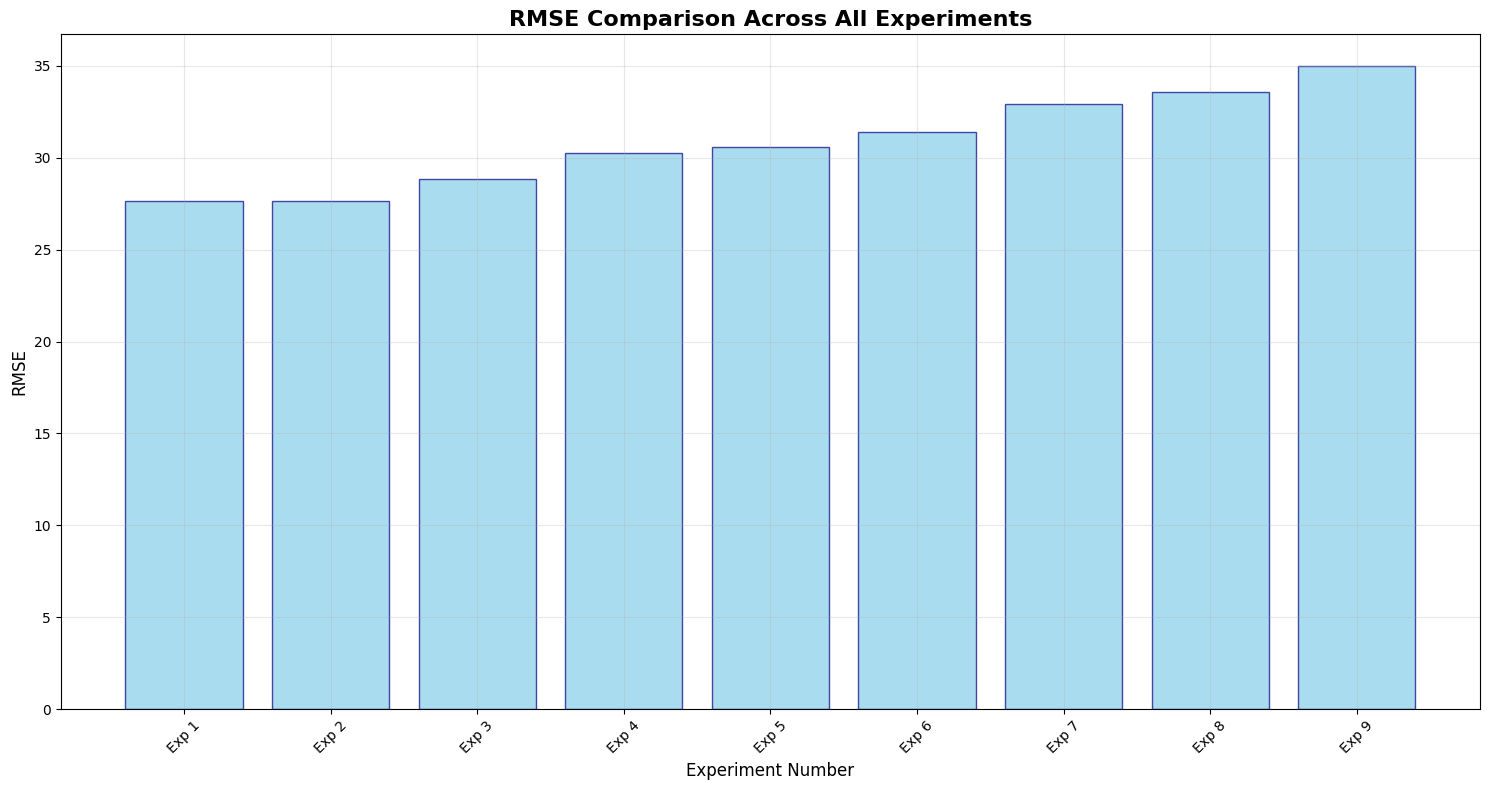

In [42]:
#RMSE Definition and Formula
print("Root Mean Squared Error (RMSE) Definition:")
print("RMSE measures the average prediction error magnitude. It's calculated as:")
print("RMSE = √(Σ(y_actual - y_predicted)² / n)")
print("where n is the number of predictions.")
print("Lower RMSE indicates better prediction accuracy.\n")

# Find best model
best_idx = experiments_df.index[0]
best_model_name = experiments_df.iloc[0]['experiment_name']
best_rmse = experiments_df.iloc[0]['rmse']

print(f"Best Model: {best_model_name}")
print(f"Best RMSE: {best_rmse:.2f}")

# Plot experiment results
plt.figure(figsize=(15, 8))
plt.bar(range(len(experiments_df)), experiments_df['rmse'], color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Experiment Number', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE Comparison Across All Experiments', fontsize=16, fontweight='bold')
plt.xticks(range(len(experiments_df)), [f"Exp {i+1}" for i in range(len(experiments_df))], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FINAL: Display Best Experiment, Train Final Model, Predict & Save Submission

Best experiment: Optimized GRU Model (RMSE=27.64)

=== Training Final Optimized LSTM ===
Epoch 1/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 0.0039 - mae: 0.0424 - val_loss: 0.0028 - val_mae: 0.0330 - learning_rate: 7.0000e-04
Epoch 2/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0018 - mae: 0.0272 - val_loss: 0.0019 - val_mae: 0.0267 - learning_rate: 7.0000e-04
Epoch 3/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.0014 - mae: 0.0240 - val_loss: 0.0015 - val_mae: 0.0232 - learning_rate: 7.0000e-04
Epoch 4/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.0012 - mae: 0.0215 - val_loss: 0.0013 - val_mae: 0.0212 - learning_rate: 7.0000e-04
Epoch 5/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0010 - mae: 0.0200 - val_loss: 0.0011 - val_mae: 0.0199 - learning_rate: 7.0000e-04
Epoch 6/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 9.9121e-04 - mae: 0.0192 - val_loss: 0.0011 - val_mae: 0.0195 - learning_rate: 7.0000e-04
Epoch 7/10
681/681 

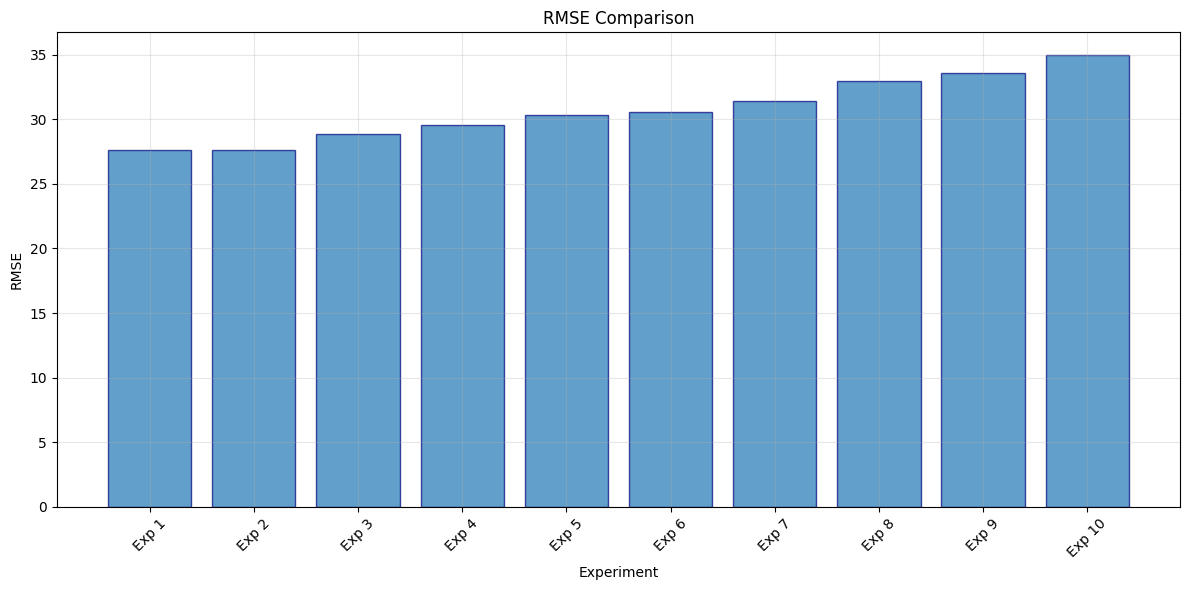

ValueError: X has 11 features, but MinMaxScaler is expecting 24 features as input.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Show best experiment
best_experiment = min(experiments, key=lambda x: x['rmse'])
print(f"Best experiment: {best_experiment['experiment_name']} (RMSE={best_experiment['rmse']:.2f})")

# 2. Train final optimized model
model_params_final = {
    'lstm_units': 90,
    'dropout_rate': 0.15,
    'dense_units': 45,
    'learning_rate': 0.0007,
    'batch_size': 36,
    'optimizer_name': 'adam'
}
final_model, final_history, final_rmse = train_and_evaluate_model(
    model_params_final,
    experiment_name="Final Optimized LSTM"
)
print(f"Final model RMSE: {final_rmse:.2f}")

# 3. Show experiments table & RMSE plot
experiments_df = pd.DataFrame(experiments).sort_values('rmse')
print("\n" + "="*80)
print("EXPERIMENT RESULTS")
print("="*80)
print(experiments_df.to_string(index=False))

plt.figure(figsize=(12,6))
plt.bar(range(len(experiments_df)), experiments_df['rmse'], alpha=0.7, edgecolor='navy')
plt.xticks(range(len(experiments_df)), [f"Exp {i+1}" for i in range(len(experiments_df))], rotation=45)
plt.xlabel('Experiment'); plt.ylabel('RMSE')
plt.title('RMSE Comparison'); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


X_test_raw = test[feature_cols]  # select same columns
X_test_num = X_test_raw.apply(pd.to_numeric, errors='coerce')
X_test_num = X_test_num.fillna(method='ffill').fillna(0)

# scale
X_test_scaled = scaler_X.transform(X_test_num)

if sequence_length > 1:
    X_seq = [
        X_test_scaled[i : i + sequence_length]
        for i in range(len(X_test_scaled) - sequence_length + 1)
    ]
    X_test_input = np.array(X_seq, dtype=np.float32)
else:
    X_test_input = X_test_scaled.astype(np.float32)
    X_test_input = np.expand_dims(X_test_input, axis=1)

print("Prepared X_test_input shape:", X_test_input.shape)

# 5. Predict
preds = final_model.predict(X_test_input)
preds = np.nan_to_num(preds)
preds = np.round(preds).astype(int).flatten()

# 6. Build and save submission
row_ids_full = pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S')
row_ids = row_ids_full[-len(preds):]

submission = pd.DataFrame({'row ID': row_ids, 'pm2.5': preds})
submission = submission.sort_values('row ID')

out_path = '/content/drive/MyDrive/ALU/Kaggle/air_quality_forecasting/subm_fixed.csv'
submission.to_csv(out_path, index=False)
print(f"Saved submission to {out_path}")
